##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 합성곱 신경망 사용해 hand-drawn shape 분류하기
### https://www.kaggle.com/datasets/frobert/handdrawn-shapes-hds-dataset


In [2]:
import tensorflow as tf
import os
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import random

2022-11-01 02:29:12.147546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 02:29:12.257329: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-01 02:29:12.756658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-01 02:29:12.756701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
# 데이터 확인

# 유저 수 확인

users = os.listdir("./data")
print(len(users))

37


In [6]:
train_users = users[:30]
test_users = users[30:-1]
print("<train>")
print(train_users)
print()
print("<test>")
print(test_users)
print()
print("<gradio_sample>")
print(users[-1])

<train>
['user.u17', 'user.crt', 'user.u01', 'user.u19', 'user.u18', 'user.if3', 'user.if5', 'user.if2', 'user.im1', 'user.u02', 'user.if1', 'user.if8', 'user.il1', 'user.u13', 'user.u03', 'user.u06', 'user.lrt', 'user.vly', 'user.drt', 'user.mrt', 'user.elu', 'user.u09', 'user.u08', 'user.ilb', 'user.frt', 'user.nld', 'user.aly', 'user.u10', 'user.lt1', 'user.nae']

<test>
['user.u07', 'user.u14', 'user.u05', 'user.u11', 'user.u12', 'user.u04']

<gradio_sample>
user.lts


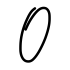

In [7]:
from PIL import Image
img_pil = Image.open("data/user.nae/images/ellipse/ellipse.nae.0001.png")
img_pil_cvt = img_pil.convert('RGB') # rgb로 변경
img_pil_cvt


In [8]:
img_array = np.array(img_pil_cvt)
img_array.shape


(70, 70, 3)

In [9]:
# train_images, train_labels 나누기

# label -> ellipse 0    /   rectagle 1   triangle 2

train_images = []
train_labels=[]
for username in train_users:
    shapes = ["ellipse","rectangle","triangle"]
    for index,shape in enumerate(shapes):
        if shape in os.listdir(f"./data/{username}/images"):
            img_list_ellipse = os.listdir(f"./data/{username}/images/{shape}")
            for img_name in img_list_ellipse:
                img_path = f"./data/{username}/images/{shape}/{img_name}"
                img_pil = Image.open(img_path)
                img_pil_cvt = img_pil.convert('RGB') # rgb로 변경
                img_array = np.array(img_pil_cvt)
                train_images.append(img_array)
                train_labels.append([index])

s_zip = list(zip(train_images, train_labels)) 

random.shuffle(s_zip)

train_images, train_labels = zip(*s_zip)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [10]:
print(type(train_images))
print(train_images.shape)
print(train_labels.shape)

<class 'numpy.ndarray'>
(16473, 70, 70, 3)
(16473, 1)


In [11]:
# test_images, test_labels 나누기

# label -> ellipse 0    /   rectagle 1   triangle 2

test_images = []
test_labels=[]
for username in test_users:
    shapes = ["ellipse","rectangle","triangle"]
    for index,shape in enumerate(shapes):
        if shape in os.listdir(f"./data/{username}/images"):
            img_list_ellipse = os.listdir(f"./data/{username}/images/{shape}")
            for img_name in img_list_ellipse:
                img_path = f"./data/{username}/images/{shape}/{img_name}"
                img_pil = Image.open(img_path)
                img_pil_cvt = img_pil.convert('RGB') # rgb로 변경
                img_array = np.array(img_pil_cvt)
                test_images.append(img_array)
                test_labels.append([index])


s_zip = list(zip(test_images, test_labels)) 

random.shuffle(s_zip)

test_images, test_labels = zip(*s_zip)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [12]:
print(type(test_images))
print(test_images.shape)
print(test_labels.shape)

<class 'numpy.ndarray'>
(2378, 70, 70, 3)
(2378, 1)


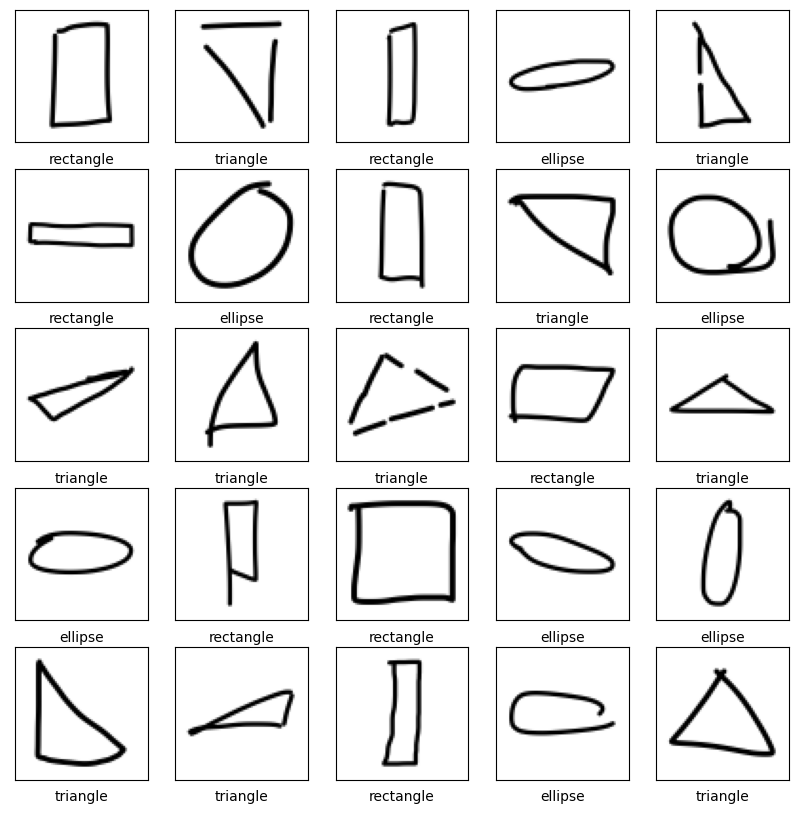

In [13]:
class_names = ["ellipse","rectangle","triangle"]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### 텐서플로 임포트하기

In [14]:
# !pip install -q tensorflow-gpu==2.0.0-rc1
# import tensorflow as tf

from tensorflow.keras import datasets, layers, models

In [15]:
# Set image properties
image_size  = 70     # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [16]:
train_images[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [17]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### 합성곱 층 만들기

아래 6줄의 코드에서 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의합니다.

CNN은 배치(batch) 크기를 제외하고 (이미지 높이, 이미지 너비, 컬러 채널) 크기의 텐서(tensor)를 입력으로 받습니다. MNIST 데이터는 (흑백 이미지이기 때문에) 컬러 채널(channel)이 하나지만 컬러 이미지는 (R,G,B) 세 개의 채널을 가집니다. 이 예에서는 MNIST 이미지 포맷인 (28, 28, 1) 크기의 입력을 처리하는 CNN을 정의하겠습니다. 이 값을 첫 번째 층의 `input_shape` 매개변수로 전달합니다.

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(70, 70, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

2022-11-01 02:30:38.075519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 02:30:38.076505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 02:30:38.077474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 02:30:38.083686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 02:30:38.084654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

지금까지 모델의 구조를 출력해 보죠.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

위에서 Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서입니다. 높이와 너비 차원은 네트워크가 깊어질수록 감소하는 경향을 가집니다. Conv2D 층에서 출력 채널의 수는 첫 번째 매개변수에 의해 결정됩니다(예를 들면, 32 또는 64). 일반적으로 높이와 너비가 줄어듦에 따라 (계산 비용 측면에서) Conv2D 층의 출력 채널을 늘릴 수 있습니다.

### 마지막에 Dense 층 추가하기

모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (4, 4, 64))를 하나 이상의 Dense 층에 주입하여 분류를 수행합니다. Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서입니다. 먼저 3D 출력을 1D로 펼치겠습니다. 그다음 하나 이상의 Dense 층을 그 위에 추가하겠습니다. MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용합니다.

In [20]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

최종 모델의 구조를 확인해 보죠.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0

여기에서 볼 수 있듯이 두 개의 Dense 층을 통과하기 전에 (4, 4, 64) 출력을 (1024) 크기의 벡터로 펼쳤습니다.

### 모델 컴파일과 훈련하기

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(train_images, train_labels, epochs=10)

Epoch 1/10


2022-11-01 02:32:14.661107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-11-01 02:32:15.392375: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  1/515 [..............................] - ETA: 19:12 - loss: 2.3827 - accuracy: 0.0000e+00

2022-11-01 02:32:15.909110: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


515/515 [==============================] - 4s 4ms/step - loss: 0.4767 - accuracy: 0.8053
Epoch 2/10
515/515 [==============================] - 2s 3ms/step - loss: 0.1706 - accuracy: 0.9394
Epoch 3/10
515/515 [==============================] - 2s 3ms/step - loss: 0.1003 - accuracy: 0.9650
Epoch 4/10
515/515 [==============================] - 2s 3ms/step - loss: 0.0634 - accuracy: 0.9784
Epoch 5/10
515/515 [==============================] - 2s 3ms/step - loss: 0.0485 - accuracy: 0.9834
Epoch 6/10
515/515 [==============================] - 2s 3ms/step - loss: 0.0313 - accuracy: 0.9897
Epoch 7/10
515/515 [==============================] - 2s 3ms/step - loss: 0.0216 - accuracy: 0.9927
Epoch 8/10
515/515 [==============================] - 2s 3ms/step - loss: 0.0259 - accuracy: 0.9922
Epoch 9/10
515/515 [==============================] - 2s 3ms/step - loss: 0.0162 - accuracy: 0.9947
Epoch 10/10
515/515 [==============================] - 2s 3ms/step - loss: 0.0214 - accuracy: 0.9924


### 모델 평가

In [23]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

75/75 - 0s - loss: 0.0139 - accuracy: 0.9950 - 260ms/epoch - 3ms/step


In [24]:
print(test_acc)

0.9949537515640259


In [29]:
model.save("cnn_hand_drawn")

INFO:tensorflow:Assets written to: cnn_hand_drawn/assets


INFO:tensorflow:Assets written to: cnn_hand_drawn/assets


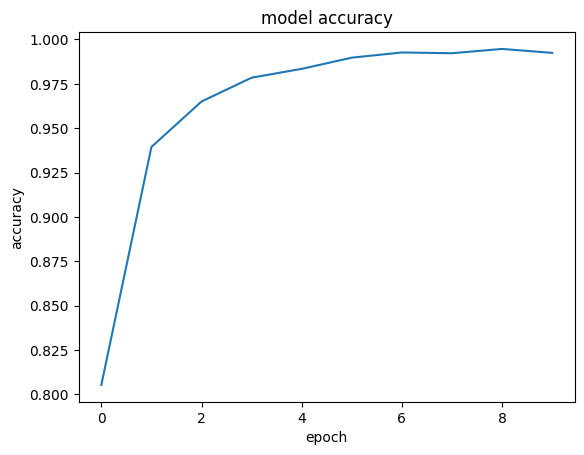

In [28]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

결과에서 보듯이 간단한 CNN 모델이 99%의 테스트 정확도를 달성합니다. 몇 라인의 코드치고 나쁘지 않네요! (케라스의 서브클래싱 API와 GradientTape를 사용하여) CNN을 만드는 또 다른 방법은 [여기](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/quickstart/advanced.ipynb)를 참고하세요.